# 1. Install required libraries

In [1]:
# !git clone --quiet https://github.com/faizankshaikh/ForaGym.git
# %cd ForaGym
# !pip install -q -e .
# !pip install stable-baselines3

# 2. Create Gym environment

In [2]:
# import important libs and modules
import gym
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces

from stable_baselines3 import DQN, PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from imitation.data import rollout
from imitation.algorithms import bc
from imitation.data.types import load_with_rewards
from imitation.util.networks import RunningNorm
from imitation.algorithms.adversarial.gail import GAIL
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicRewardNet

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
# initiatlize gym env
env = gym.make("foragym:foragym/ForaGym-v1", items_path="../foragym/data/items_with_threat.csv", render_mode="human") 
env_suppressed = gym.make("foragym:foragym/ForaGym-v1", render_mode=None)

In [4]:
# visualize transition matrix
## TODO - convert dict to pandas DF
num_states = env.nS
num_actions = env.nA

cnt = 0
for state in range(num_states):
    for action in range(num_actions):
        for items in env.P[state][action]:
            try:
                days_left, life_point, forest_type = env.decode(state)
                p, new_state, reward, done = items
                print("="*10)
                print(f"enc_state: {state}, days_left: {days_left}, life_point: {life_point}, forest_type: {forest_type}")
                print(f"action: {env.action_dict[action]}, new_state: {new_state}, p: {round(p, 3):.3f}, reward: {reward}, is_dead: {done}")
                print("="*10)
            except:
                pass
            if cnt > 5:
                break
            cnt += 1

    if cnt > 5:
        break

enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: wait, new_state: 0, p: 1.000, reward: -1, is_dead: True
enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: forage, new_state: 0, p: 0.333, reward: -1, is_dead: True
enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: forage, new_state: 0, p: 0.125, reward: -1, is_dead: True
enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: forage, new_state: 144.0, p: 0.167, reward: 0, is_dead: True
enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: forage, new_state: 144.0, p: 0.125, reward: 0, is_dead: True
enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: forage, new_state: 0, p: 0.000, reward: -1, is_dead: True
enc_state: 576, days_left: 1, life_point: 1, forest_type: 0
action: forage, new_state: 0, p: 0.250, reward: -1, is_dead: True


# 3. Solve the foraging task

## 3.1 Heuristic method

In [5]:
# run algorithm on sample episodes
num_episodes = 2

for episode in range(num_episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)

    done = False
    print("Initial state:-")
    obs = env.reset()
    print()

    while not done:
        action = 1 #env.action_space.sample()
        print(f"Action to take: {env.action_dict[action]}")
        print()
        obs, reward, done, info = env.step(action)
        print()

    print("-" * 10)

Episode #1
Initial state:-
--Forest Quality for the left environment: 0.40
--Threat Encounter probability for the left environment: 0.00
--Nutritional Quality for the left environment: 1.00
--Forest Quality for the right environment: 0.43
--Threat Encounter probability for the right environment: 0.29
--Nutritional Quality for the right environment: 1.00
----------

--Days left: 7
--Current life: 4
--Current Forest Quality: 0.43
--Current Threat Encounter probability: 0.29
--Current Nutritional Quality: 1.00

Action to take: forage

--Consequence: Right environment / Forage failed / No threat encountered
--Reward?: 0
--Episode done?: False
--Days left: 6
--Current life: 2
--Current Forest Quality: 0.40
--Current Threat Encounter probability: 0.00
--Current Nutritional Quality: 1.00

Action to take: forage

--Consequence: Left environment / Forage failed / No threat encountered
--Reward?: -1
--Episode done?: True
--Days left: 5
--Current life: 0
--Current Forest Quality: 0.43
--Current T

In [6]:
# evaluate algorithm
num_episodes = 1000
episode_reward = []

for episode in range(num_episodes):
    done = False
    obs = env_suppressed.reset()

    total_reward = 0

    while not done:
        action = 0 #env.action_space.sample()
        obs, reward, done, info = env_suppressed.step(action)

        total_reward += reward

    episode_reward.append(total_reward)

print(f"mean_reward:{np.mean(episode_reward):.2f}")


mean_reward:-1.00


## 3.2 Value Iteration method

In [7]:
# init variables
env.action_dict[2] = "Indifference"

num_actions = env.nA
num_states = env.nS
num_internal_states = env.num_days * env.num_life_points

V_list = []
policy_list = []

# init values list
for forest_type in range(0, env.num_forests):
	V = np.zeros(num_internal_states)
	optimal_policy = np.zeros([num_states, num_actions + 1])

	for days_left in range(env.num_days):
		for life_points_left in range(env.num_life_points):
			if life_points_left == 0:
				V[days_left*env.num_life_points] = -1

	V_list.append(V)
	policy_list.append(optimal_policy)

# find optimal policy
for forest_type in range(0, env.num_forests):
	V = V_list[forest_type]
	optimal_policy = policy_list[forest_type]

	for days_left in range(1, env.num_days):
		for life_points_left in range(1, env.num_life_points):
			curr_internal_state = (days_left*env.num_life_points) + life_points_left
			enc_state = env.encode(days_left, life_points_left, forest_type)
			actions_s = np.zeros(num_actions)

			for action in range(env.nA):
				for transition_prob, next_enc_state, reward, done in env.P[enc_state][action]:
					next_days_left, next_life_points_left, _ = env.decode(next_enc_state)
					next_state = int((next_days_left * env.num_life_points) + next_life_points_left)
					if done:
						actions_s[action] += transition_prob * (reward)
					else:
						actions_s[action] += transition_prob * (reward + V[next_state])

			V[curr_internal_state] = actions_s.max()
			if actions_s[0] != actions_s[1]:
				optimal_policy[curr_internal_state, np.argmax(actions_s)] = 1.0
			else:
				optimal_policy[curr_internal_state, 2] = 1.0

	V_list.append(V)
	policy_list.append(optimal_policy)

for days_left in range(1, env.num_days):
	for life_points_left in range(1, env.num_life_points):
		for forest_type in range(0, env.num_forests):
			curr_state = (days_left*env.num_life_points) + life_points_left
			forest_quality_left = env.forests.loc[env.forests["forest_type"] == forest_type, "forest_quality_left"].values[0]
			threat_encounter_left = env.forests.loc[env.forests["forest_type"] == forest_type, "threat_encounter_left"].values[0]
			nutritional_quality_left = env.forests.loc[env.forests["forest_type"] == forest_type, "nutritional_quality_left"].values[0]
			forest_quality_right = env.forests.loc[env.forests["forest_type"] == forest_type, "forest_quality_right"].values[0]
			threat_encounter_right = env.forests.loc[env.forests["forest_type"] == forest_type, "threat_encounter_right"].values[0]
			nutritional_quality_right = env.forests.loc[env.forests["forest_type"] == forest_type, "nutritional_quality_right"].values[0]
			V = V_list[forest_type]
			optimal_policy = policy_list[forest_type]
			print(f"days_left: {days_left}, life_points: {life_points_left}, FQ_left: {forest_quality_left:.3f}, FQ_right: {forest_quality_right:.3f}, threat_left: {threat_encounter_left:.3f}, threat_right: {threat_encounter_right:.3f}:- action: {env.action_dict[np.argmax(optimal_policy[curr_state])]}, value: {V[curr_state]:.3f}")

days_left: 1, life_points: 1, FQ_left: 0.333, FQ_right: 0.500, threat_left: 0.000, threat_right: 0.500:- action: forage, value: -0.708
days_left: 1, life_points: 1, FQ_left: 0.600, FQ_right: 0.625, threat_left: 0.000, threat_right: 0.250:- action: forage, value: -0.466
days_left: 1, life_points: 1, FQ_left: 0.600, FQ_right: 0.667, threat_left: 0.000, threat_right: 0.333:- action: forage, value: -0.478
days_left: 1, life_points: 1, FQ_left: 0.600, FQ_right: 0.625, threat_left: 0.000, threat_right: 0.250:- action: forage, value: -0.466
days_left: 1, life_points: 1, FQ_left: 0.250, FQ_right: 0.286, threat_left: 0.000, threat_right: 0.286:- action: forage, value: -0.773
days_left: 1, life_points: 1, FQ_left: 0.500, FQ_right: 0.571, threat_left: 0.000, threat_right: 0.286:- action: forage, value: -0.546
days_left: 1, life_points: 1, FQ_left: 0.400, FQ_right: 0.429, threat_left: 0.000, threat_right: 0.286:- action: forage, value: -0.647
days_left: 1, life_points: 1, FQ_left: 0.500, FQ_right:

In [8]:
# run algorithm on sample episodes
num_episodes = 2

for episode in range(num_episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)

    done = False
    print("Initial state:-")
    obs = env.reset()
    print()

    while not done:
        enc_state = env.encode(obs["days_left"], obs["life_points_left"], env.forest_type)
        optimal_policy = policy_list[env.forest_type]
        curr_state = (obs["days_left"]*env.num_life_points) + obs["life_points_left"]
        action = np.argmax(optimal_policy[curr_state])
        if action > 1:
            action = 1 
        print(f"Action to take: {env.action_dict[action]}")
        print()
        obs, reward, done, info = env.step(action)
        print()

    print("-" * 10)

Episode #1
Initial state:-
--Forest Quality for the left environment: 0.40
--Threat Encounter probability for the left environment: 0.00
--Nutritional Quality for the left environment: 2.00
--Forest Quality for the right environment: 0.43
--Threat Encounter probability for the right environment: 0.29
--Nutritional Quality for the right environment: 2.00
----------

--Days left: 7
--Current life: 5
--Current Forest Quality: 0.43
--Current Threat Encounter probability: 0.29
--Current Nutritional Quality: 2.00

Action to take: wait

--Consequence: Waited
--Reward?: 0
--Episode done?: False
--Days left: 6
--Current life: 4
--Current Forest Quality: 0.40
--Current Threat Encounter probability: 0.00
--Current Nutritional Quality: 2.00

Action to take: forage

--Consequence: Left environment / Forage failed / No threat encountered
--Reward?: 0
--Episode done?: False
--Days left: 5
--Current life: 2
--Current Forest Quality: 0.43
--Current Threat Encounter probability: 0.29
--Current Nutrition

In [9]:
# evaluate algorithm
num_episodes = 1000
episode_reward = []

for episode in range(num_episodes):
    done = False
    obs = env_suppressed.reset()

    total_reward = 0

    while not done:
        enc_state = env_suppressed.encode(obs["days_left"], obs["life_points_left"], env_suppressed.forest_type)
        optimal_policy = policy_list[env_suppressed.forest_type]
        curr_state = (obs["days_left"]*env_suppressed.num_life_points) + obs["life_points_left"]
        action = np.argmax(optimal_policy[curr_state])
        if action > 1:
            action = 1 
        obs, reward, done, info = env_suppressed.step(action)

        total_reward += reward

    episode_reward.append(total_reward)

print(f"mean_reward:{np.mean(episode_reward):.2f}")

mean_reward:-0.59


## 3.3 DQN (Stable baselines)

In [10]:
# create model and train
model = DQN('MultiInputPolicy', env_suppressed).learn(total_timesteps=int(2e4))

In [11]:
# run algorithm on sample episodes
num_episodes = 2

for episode in range(num_episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)

    done = False
    print("Initial state:-")
    obs = env.reset()
    print()

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        print(f"Action to take: {env.action_dict[action]}")
        print()
        obs, reward, done, info = env.step(action)
        print()

    print("-" * 10)

Episode #1
Initial state:-
--Forest Quality for the left environment: 0.57
--Threat Encounter probability for the left environment: 0.00
--Nutritional Quality for the left environment: 2.00
--Forest Quality for the right environment: 0.62
--Threat Encounter probability for the right environment: 0.25
--Nutritional Quality for the right environment: 2.00
----------

--Days left: 7
--Current life: 5
--Current Forest Quality: 0.62
--Current Threat Encounter probability: 0.25
--Current Nutritional Quality: 2.00

Action to take: wait

--Consequence: Waited
--Reward?: 0
--Episode done?: False
--Days left: 6
--Current life: 4
--Current Forest Quality: 0.57
--Current Threat Encounter probability: 0.00
--Current Nutritional Quality: 2.00

Action to take: wait

--Consequence: Waited
--Reward?: 0
--Episode done?: False
--Days left: 5
--Current life: 3
--Current Forest Quality: 0.62
--Current Threat Encounter probability: 0.25
--Current Nutritional Quality: 2.00

Action to take: wait

--Consequenc

In [12]:
# evaluate algorithm
num_episodes = 1000
episode_reward = []

for episode in range(num_episodes):
    done = False
    obs = env_suppressed.reset()

    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env_suppressed.step(action)

        total_reward += reward

    episode_reward.append(total_reward)

print(f"mean_reward:{np.mean(episode_reward):.2f}")

mean_reward:-1.00


In [13]:
reward_dqn, _ = evaluate_policy(model, env_suppressed, 1000)
print(f"DQN's performance: {reward_dqn}")

c:\Users\faiza\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


DQN's performance: -1.0


## 3.4 Behavioral Cloning from Synthetic Expert

In [14]:
class CustomFlattenObservation(gym.ObservationWrapper):
    def __init__(self, env, with_scaling=False):
        super().__init__(env)
        self.with_scaling = with_scaling

        high = 10.
        if self.with_scaling:
            high = 1.

        self.observation_space = spaces.Box(low=0, high=high, shape=(1,5), dtype=np.float32)
    
    def observation(self, obs):

        days_left = np.asarray(obs["days_left"], dtype=np.float32).flatten()
        life_points_left = np.asarray(obs["life_points_left"], dtype=np.float32).flatten()
        environment = np.asarray(obs["environment"], dtype=np.float32).flatten()

        if self.with_scaling:
            days_left /= 8
            life_points_left /= 7

        return np.expand_dims(np.concatenate([days_left, life_points_left, environment], dtype=np.float32), axis=0)

In [15]:
wrapped_env_unscaled = CustomFlattenObservation(env, with_scaling=False)
wrapped_env_scaled = CustomFlattenObservation(env, with_scaling=True)
wrapped_env_unscaled_suppressed = CustomFlattenObservation(env_suppressed, with_scaling=True)
wrapped_env_scaled_suppressed = CustomFlattenObservation(env_suppressed, with_scaling=True)

In [16]:
venv = DummyVecEnv([lambda: RolloutInfoWrapper(wrapped_env_scaled_suppressed)])

expert = PPO(
    policy=MlpPolicy,
    env=venv
)

expert.learn(1e4)

In [17]:
reward_expert, _ = evaluate_policy(expert, wrapped_env_scaled_suppressed, 1000)
print(f"Expert's performance: {reward_expert}")

c:\Users\faiza\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Expert's performance: -0.686


In [18]:
rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
    rng=rng,
    exclude_infos=True
)
rollouts[0]

TrajectoryWithRew(obs=array([[[0.875     , 0.5714286 , 0.5       , 0.        , 2.        ]],

       [[0.75      , 0.85714287, 0.5714286 , 0.2857143 , 2.        ]],

       [[0.625     , 0.71428573, 0.5       , 0.        , 2.        ]],

       [[0.5       , 0.5714286 , 0.5714286 , 0.2857143 , 2.        ]],

       [[0.375     , 0.85714287, 0.5714286 , 0.2857143 , 2.        ]],

       [[0.25      , 0.71428573, 0.5714286 , 0.2857143 , 2.        ]],

       [[0.125     , 0.5714286 , 0.5714286 , 0.2857143 , 2.        ]],

       [[0.        , 0.2857143 , 0.5       , 0.        , 2.        ]]],
      dtype=float32), acts=array([1, 0, 0, 1, 0, 0, 1], dtype=int64), infos=None, terminal=True, rews=array([0., 0., 0., 0., 0., 0., 0.]))

In [19]:
trajectories = rollout.flatten_trajectories(rollouts)
len(trajectories)

269

In [20]:
bc_trainer = bc.BC(
    observation_space=wrapped_env_scaled_suppressed.observation_space,
    action_space=wrapped_env_scaled_suppressed.action_space,
    demonstrations=trajectories
)

In [21]:
bc_trainer.train(n_epochs=1000, progress_bar=False)

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 37.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------
---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000544 |
|    entropy        | 0.544     |
|    epoch          | 62        |
|    l2_loss        | 0         |
|    l2_norm        | 45.9      |
|    loss           | 0.442     |
|    neglogp        | 0.442     |
|    prob_true_act  | 0.675     |
|    samples_so_far | 16032     |
---------------------------------
---------------------------------
| batch_size  

In [22]:
reward_after_training, _ = evaluate_policy(bc_trainer.policy, wrapped_env_scaled_suppressed, 1000)
print(f"Reward after training (from trained behavioural cloning): {reward_after_training}")

c:\Users\faiza\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward after training (from trained behavioural cloning): -0.729


## 3.5 GAIL from Synthetic Expert

In [23]:
learner = PPO(
    env=venv,
    policy=MlpPolicy
)

In [24]:
reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=32,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

gail_trainer.train(10000)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/guide/variable_horizon.html for more information.


round:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------------
| raw/                        |      |
|    gen/time/fps             | 650  |
|    gen/time/iterations      | 1    |
|    gen/time/time_elapsed    | 3    |
|    gen/time/total_timesteps | 2048 |
--------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.689    |
|    disc/disc_loss                   | 0.702    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 32       |
|    disc/n_generated                 | 32       |
--------------------------------------------------
--------------------------------------------------
| raw/       

round:  25%|██▌       | 1/4 [00:04<00:13,  4.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 3.55        |
|    gen/time/fps                    | 666         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 4096        |
|    gen/train/approx_kl             | 0.010708211 |
|    gen/train/clip_fraction         | 0.0549      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.683      |
|    gen/train/explained_variance    | -0.000289   |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.15        |
|    gen/train/n_updates             | 10          |
|    gen/train/policy_gradient_loss  | -0.00626    |
|    gen/train/value_loss            | 0.966       |
----------------------------------------------------
----------------------------------------------

round:  50%|█████     | 2/4 [00:09<00:09,  4.69s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_rew_wrapped_mean | 3.85        |
|    gen/time/fps                    | 676         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 6144        |
|    gen/train/approx_kl             | 0.011153223 |
|    gen/train/clip_fraction         | 0.104       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.651      |
|    gen/train/explained_variance    | 0.555       |
|    gen/train/learning_rate         | 0.0003      |
|    gen/train/loss                  | 0.299       |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.00984    |
|    gen/train/value_loss            | 0.671       |
----------------------------------------------------
----------------------------------------------

round:  75%|███████▌  | 3/4 [00:13<00:04,  4.53s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_rew_wrapped_mean | 3.64         |
|    gen/time/fps                    | 725          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 8192         |
|    gen/train/approx_kl             | 0.0059180744 |
|    gen/train/clip_fraction         | 0.0646       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.621       |
|    gen/train/explained_variance    | 0.605        |
|    gen/train/learning_rate         | 0.0003       |
|    gen/train/loss                  | 0.382        |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | -0.00681     |
|    gen/train/value_loss            | 0.645        |
-----------------------------------------------------
----------------------------

round: 100%|██████████| 4/4 [00:17<00:00,  4.42s/it]


In [25]:
rewards, _ = evaluate_policy(learner, venv, 1000)
print("Rewards from trained GAIL:", rewards)

c:\Users\faiza\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Rewards from trained GAIL: -0.855


## 3.7 Exploring Behavioral Data from Human Experts

In [26]:
rollouts = load_with_rewards("../foragym/data/data.npz")
rollouts[0]

TrajectoryWithRew(obs=array([[7.  , 4.  , 0.3 , 0.2 , 1.  ],
       [6.  , 2.  , 0.5 , 0.25, 1.  ],
       [5.  , 3.  , 0.5 , 0.25, 1.  ],
       [4.  , 1.  , 0.5 , 0.25, 1.  ],
       [3.  , 0.  , 0.3 , 0.2 , 1.  ]]), acts=array([1, 1, 1, 1]), infos=array([{}, {}, {}, {}], dtype=object), terminal=True, rews=array([ 0.,  0.,  0., -1.]))

In [27]:
trajectories = rollout.flatten_trajectories(rollouts)
len(trajectories)

4588

In [28]:
feature_names = ["days_left", "life_points_left", "forest_quality", "threat_encounter", "nutritional_quality"]
target_names = ["wait", "forage"]

X = trajectories.obs.copy()
y = trajectories.acts.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3, criterion="entropy")
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

0.7222222222222222

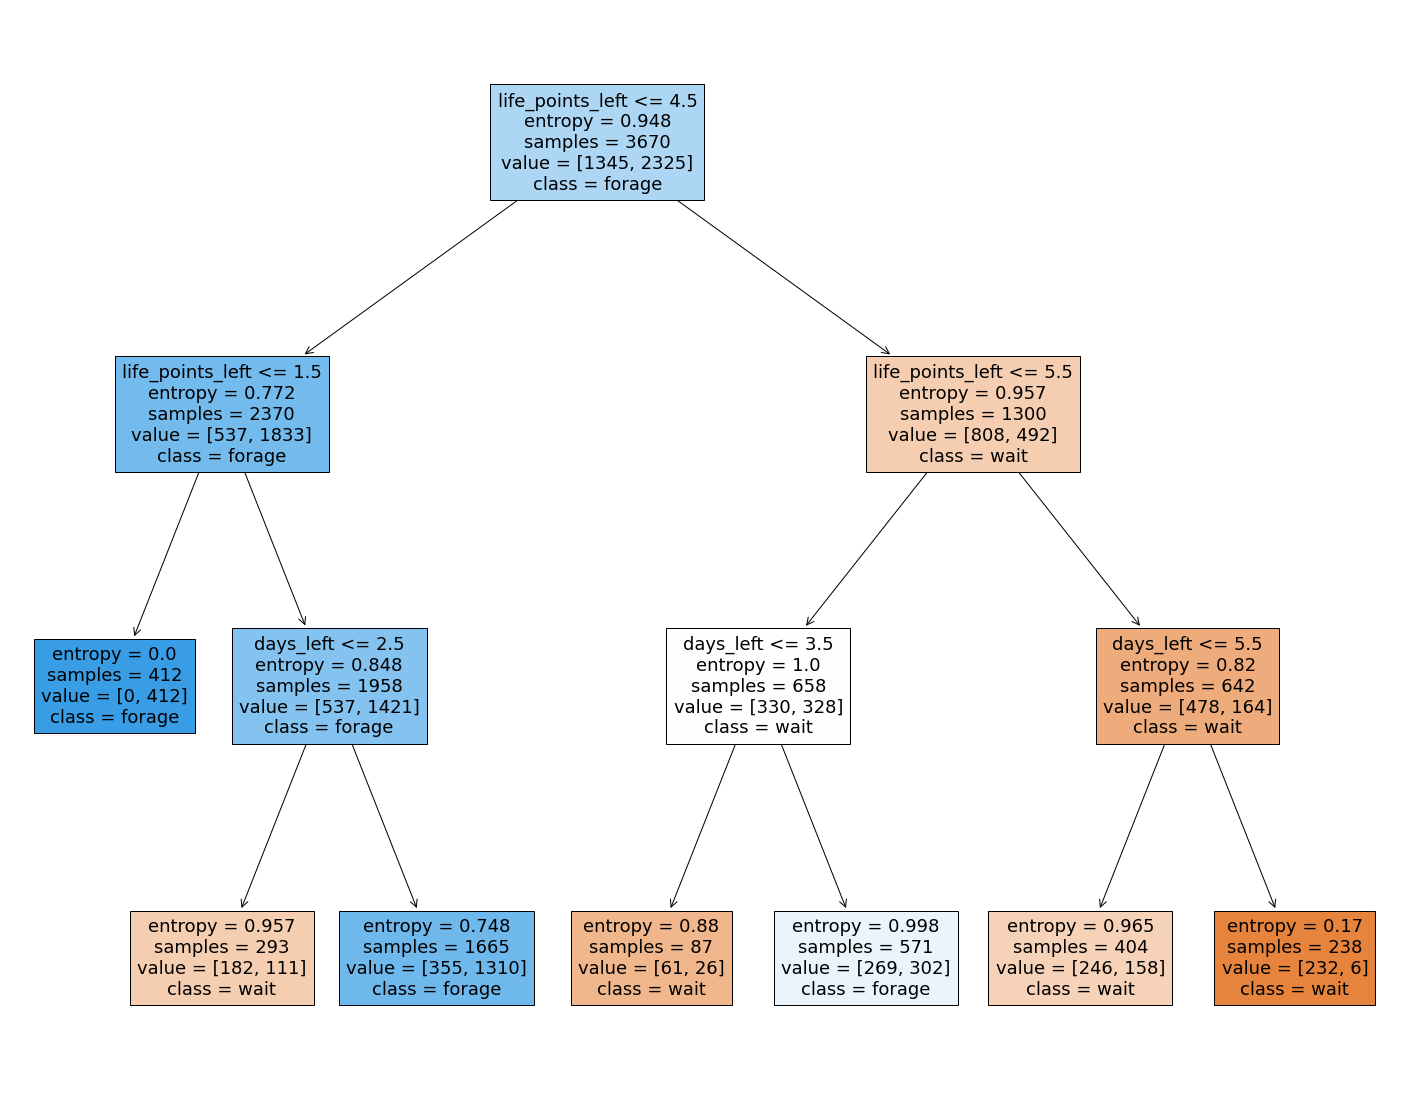

In [30]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   class_names=target_names,
                   filled=True)

In [31]:
X_train[:, 0] = X_train[:, 0] / X_train[:, 0].max()
X_train[:, 1] = X_train[:, 1] / X_train[:, 1].max()
X_train[:, -1] = X_train[:, -1] / X_train[:, -1].max()

X_test[:, 0] = X_test[:, 0] / X_test[:, 0].max()
X_test[:, 1] = X_test[:, 1] / X_test[:, 1].max()
X_test[:, -1] = X_test[:, -1] / X_test[:, -1].max()

In [32]:
rf = RandomForestClassifier(n_estimators=1000)
model = rf.fit(X_train, y_train)
model.score(X_test, y_test)

0.7777777777777778

<BarContainer object of 5 artists>

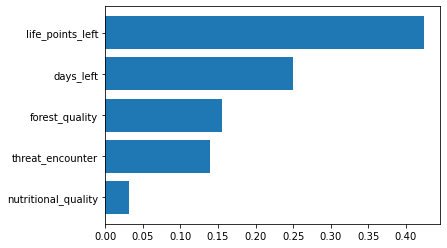

In [33]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(np.array(feature_names)[sorted_idx], model.feature_importances_[sorted_idx])

## 3.7 Behavioral Cloning from Human Expert

In [34]:
bc_trainer = bc.BC(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    demonstrations=trajectories
)

bc_trainer.train(n_epochs=100, progress_bar=False)

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 37.5      |
|    loss           | 0.69      |
|    neglogp        | 0.691     |
|    prob_true_act  | 0.501     |
|    samples_so_far | 32        |
---------------------------------
---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000567 |
|    entropy        | 0.567     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 41.8      |
|    loss           | 0.474     |
|    neglogp        | 0.475     |
|    prob_true_act  | 0.656     |
|    samples_so_far | 16032     |
---------------------------------
--------------------------------
| batch_size   

In [35]:
reward_after_training, _ = evaluate_policy(bc_trainer.policy, venv, 1000)
print(f"Reward after training(from human data): {reward_after_training}")

c:\Users\faiza\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward after training(from human data): -0.84


## 3.7 GAIL from Human Expert

In [36]:
rollouts = load_with_rewards("../foragym/data/data_preproc.npz")

In [37]:
learner = PPO(env=venv, policy=MlpPolicy)

reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=32,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=True
)

gail_trainer.train(10000)


# gail_trainer.train(10000)

# learner = PPO(
#     env=wrapped_env,
#     policy=MlpPolicy,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0003,
#     n_epochs=10,
# )
# reward_net = BasicRewardNet(
#     wrapped_env.observation_space, wrapped_env.action_space, normalize_input_layer=RunningNorm
# )
# gail_trainer = GAIL(
#     demonstrations=rollouts,
#     demo_batch_size=1024,
#     gen_replay_buffer_capacity=2048,
#     n_disc_updates_per_round=4,
#     venv=wrapped_env,
#     gen_algo=learner,
#     reward_net=reward_net,
# )

# gail_trainer.train(20000)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/guide/variable_horizon.html for more information.


round:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------------
| raw/                        |      |
|    gen/time/fps             | 732  |
|    gen/time/iterations      | 1    |
|    gen/time/time_elapsed    | 2    |
|    gen/time/total_timesteps | 2048 |
--------------------------------------


round:   0%|          | 0/4 [00:03<?, ?it/s]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)